# 1. Construction for Physics-informed Neural Networks (PINN)

- Neural Networks play the role as modeling to approximate the PDE solution with given condition.
- The Given conditions(Data-driven) solutions in PDE / ODE are set as follows:

$$u_t + N[u; \lambda ] = 0, x \in \Omega, t \in [0,T] $$

where $u(t,x)$ denotes the solution, $N[.; \lambda]$ is a nonlinear operator with parameter $\lambda$, and the domain $\Omega$ is in $\mathbb{R}^D$.
    

# 2. Solving PDE/ ODE from Neural Networks

### 1. PDE / ODE  given boundary condition and initial condition setting

The concept involves employing neural networks to solve differential equations. This is achieved by utilizing a neural network to represent the solution and training it to meet the conditions specified by initial condition and boundary condition of the differential equation.

Consider a system of partial differential equations:

- $ \frac{du}{dt} = f(u, t) $ where $ t$ is in $[0, 1]$ and

- $ u(x, 0) = u_0 $ as given boundary condition.

- $ u(0, t) = g_1(x)$ and $ u(L, t) = g_2(x)$ as given initial condition where $\Omega = [0, L]$.



### 2. Solving the PDE / ODE
To solve this, we approximate the solution as a result of a neural network:

$$ NN(t) \approx u(t) $$

For the assumption as $NN(t)$ were the true solution, then we know $ NN'(t) = f(NN(t), t) $. 

### 3.  Error estimaties by Loss(Cost) function 
Based on the above $NN(t)$, our loss function is:

$$L(\omega) = \sum_i \left(\frac{dNN(t_i)}{dt} - f(NN(t_i), t_i)\right)^2 $$

The $ t_i $ can be chosen in various ways, such as randomly or on a grid. When this loss function is minimized, we have $ \frac{dNN(t_i)}{dt} \approx f(NN(t_i), t_i) $, and thus $ NN(t)$ approximately solves the differential equation.

On the PDE domain $ \Omega \times [0, t_0]$ of $(x,t)$, to reflect the boundary condition $u_0 = u (x, 0)$ and boundary condition $u(0, t), u(L, t)$ of our solution, these terms is added to the loss function:

$$ L(\omega) = \sum_i [ \left(\frac{dNN(t_i)}{dt} - f(NN(t_i), t_i)\right)^2 + (NN(0) - u_0)^2 + (NN(0,t) - u(0,t))^2+ (NN(L,t) - u(L,t))^2] $$

Here, $ \omega $  represents the parameters defining the neural network $ NN $ that approximates $ u $. This process result in finding weights that minimize the loss function.

# 3. Example - One Dimensional Heat Equation

In [38]:
import torch
import torch.nn as nn
from torch.autograd import Variable

import numpy as np



In [39]:
device = torch.device("cpu")

### 3.1 Define the class for Neural Network
We designate Net as our solution $u_\omega (x, t)$.

When constructing the network, it's crucial to consider the number of inputs and outputs. For the input variables, there are x and t. For the output variables, there is one variable u.

We can incorporate as many hidden layers as needed, each with as many neurons as desired. A more intricate network is better equipped to discover complex solutions, but it also demands more data.

Now, create this network as the following codes.
Minimum 8 hidden layers, each containing 5 neurons. The first def code indicates linear transformation of Neural Network, and the second def code means transfromation through Sigmoid activation function.


In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,100) # number of input variables = 2, output variables = 5
        self.hidden_layer2 = nn.Linear(100,100)
        self.hidden_layer3 = nn.Linear(100,100)
        self.hidden_layer4 = nn.Linear(100,100)
        self.hidden_layer5 = nn.Linear(100,100)
        self.hidden_layer6 = nn.Linear(100,100)
        self.hidden_layer7 = nn.Linear(100,100)
        self.hidden_layer8 = nn.Linear(100,100)
        self.output_layer = nn.Linear(100,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # Merged two single-column arrays into a single array with two columns.
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs)) #Sigmoid function -> σ(x)= 1/(1+exp⁡(-x))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        layer6_out = torch.sigmoid(self.hidden_layer6(layer5_out))
        layer7_out = torch.sigmoid(self.hidden_layer7(layer6_out))
        layer8_out = torch.sigmoid(self.hidden_layer8(layer7_out))
        output = self.output_layer(layer8_out)
        ## For regression, no activation is used in output layer
        return output
# Result of the above class: 
# transformation x,t -> u -> sigmoid(u) through each hiddeon layer

### 3.2 Weight update setting - Optimizer
To iterate the nueral network, we update the weight of the linear model we set in chapter 2 by using Adam Algorithm.

In [41]:
from torch.optim import Adam
net = Net()
net = net.to(device)

# Set cost function as Mean squared error
mse_cost_function = torch.nn.MSELoss()

#Run Adam algorithm with output of the neural network processing.
optimizer = torch.optim.Adam(net.parameters()) 

### 3.3 Setting PDE with drawn u(x,t)
Employing the u(x,t) in the previous step, we set the 1-dimensional equation function f(x,t) for $ x \in [-2, 2]$ and $ t \in [0,1]$. Also we set its loss(cost) function to optimize the error bound.
The Heat equation setting is as follows with the code below:

The function $u(x, t)$, representing heat flow, needs to adhere to the partial differential equation below.
$$u_t = u_{xx}$$
Moreover, we impose two additional conditions. Initially, we set the temperature at both ends of the domain of $x$, specifying u(0, t) and u(L, t). Therefore, we assume that both ends are maintained at a temperature of 0 degrees Celsius:



In [42]:
# Partial Differential Equation (PDE) and its associated loss function.
def pde_loss(x, t, net):
    # The dependent variable 'u' is obtained from the network based on independent variables x and t.
    u = net(x, t)     
    # Before defining the PDE = du/dt - d^2(u)/(dx)^2, we need to compute du/dx and du/dt.
    u_x = torch.autograd.grad(u,x,torch.ones(u.shape),retain_graph=True,create_graph=True)[0]
    #torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x,x,torch.ones(u_x.shape),create_graph=True)[0] 
    #torch.autograd.grad(u_x.sum(), x, create_graph=True)[0]
    # torch.autograd.grad <- Computes and returns the sum of gradients of outputs with respect to the inputs.
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    pde = u_t - u_xx
    return pde


### 3.4 Boundary condition setting
Boundary condition for the heat equation is given as $u(x,0) = sin(\pi x)$ as follows. For the training data on the domain, is it used as the initial data.


In [43]:
# Data for Boundary Conditions
# Initial condition: u(x,0) = sin(pi * x)
# Boundary conditions provide initial data points for training.

# Boundary conditions state that for any x in the range [-2, 2] and time in [0, 1], the value of u is given by sin(pi * x).
# Generate 500 random numbers for x
x_bc = (2 - (-2)) *torch.rand(500,1) - 2
#np.random.uniform(low=0.0, high=6.0, size=(500,1))
t_bc = torch.zeros(500,1)

t_inner = torch.rand(500,1)
#np.zeros((500,1))
# Compute u based on the boundary condition: u(x,0) = sin(pi * x)
u_initial1 = t_bc
u_initial2 = t_bc
u_bc = np.sin(np.pi *x_bc)



### 3.5.1 Fitting model with Time-adaptive approach1 - 1st time step for $t \in [0, 0.1]$
- training with iteration 20000

We train the data while optimizing the weight in the linear model of neural network.

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.1, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

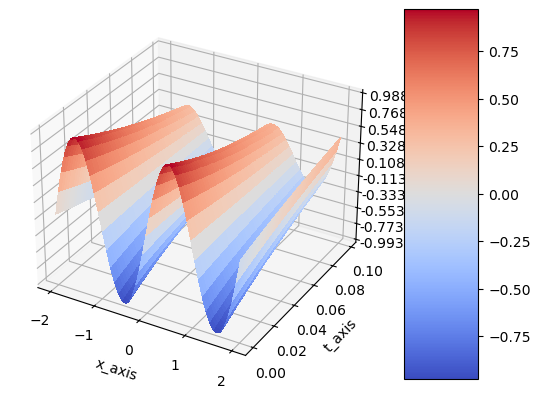

In [45]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.1, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 2nd time step for $t \in [0, 0.2]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.2, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

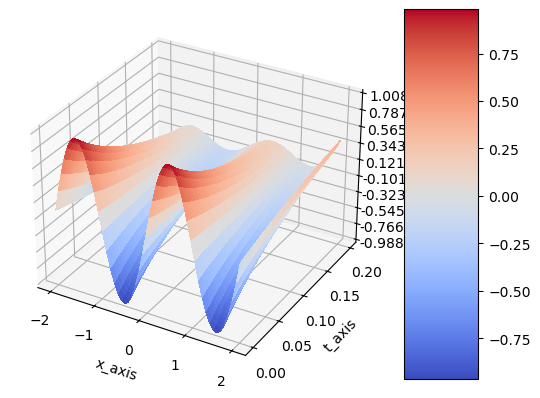

In [47]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.2, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 3rd time step for $t \in [0, 0.3]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.3, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

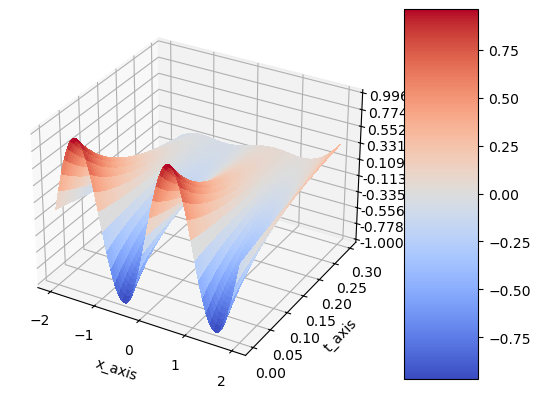

In [49]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.3, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 4th time step for $t \in [0, 0.4]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.4, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

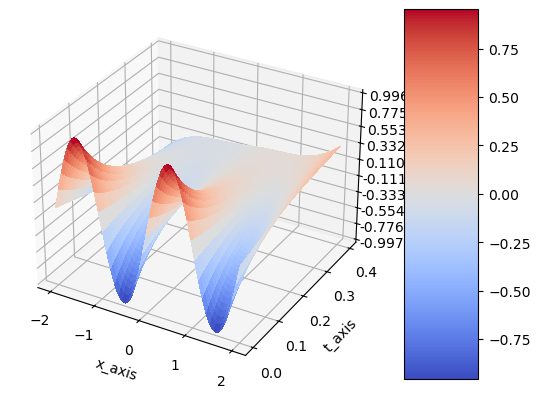

In [51]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.4, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 5th time step for $t \in [0, 0.5]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.5, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

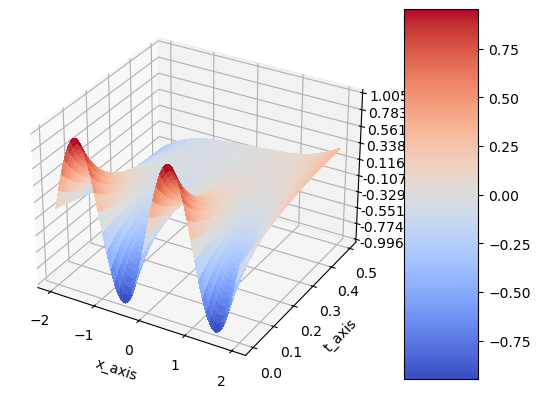

In [53]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.5, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 6th time step for $t \in [0, 0.6]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.6, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

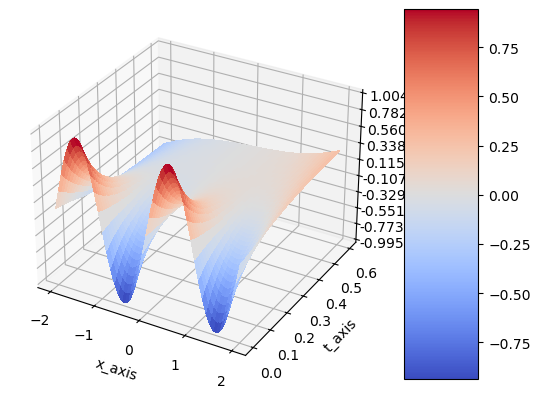

In [55]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.6, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 7th time step for $t \in [0, 0.7]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.7, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

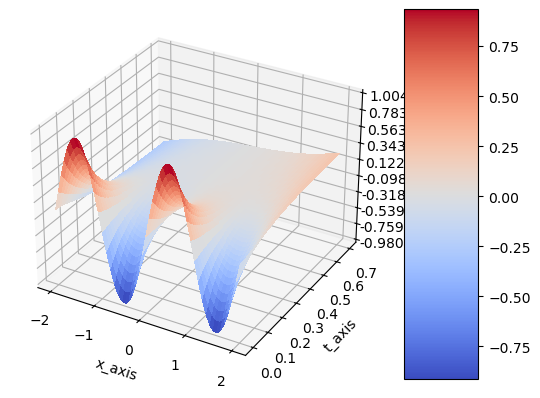

In [57]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.7, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 8th time step for $t \in [0, 0.8]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.8, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

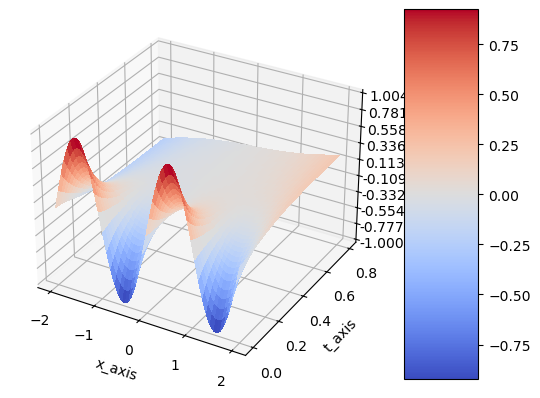

In [59]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.8, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 9th time step for $t \in [0, 0.9]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=0.9, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

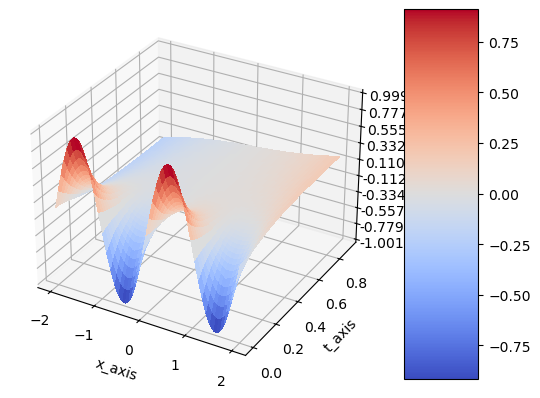

In [61]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 0.9, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.5.2 Fitting model with Time-adaptive approach1 - 10th time step for $t \in [0, 1]$
- training with iteration 20000

In [ ]:
# Setting the number of iterations
num_epochs = 20000
#prev_val_loss = 9999999.0 

# Iterating through epochs
for epoch in range(num_epochs):
    # Resetting gradients to zero
    optimizer.zero_grad()

    # Loss calculation based on boundary conditions
    input_x_bc = Variable(x_bc.float(), requires_grad=False).to(device)
    #input_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    input_t_bc = Variable(t_bc.float(), requires_grad=False).to(device)
    #input_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    
    
    target_u_bc = Variable(u_bc.float(), requires_grad=False).to(device)
    #target_u_bc = Variable(torch.from_numpy(u_bc).float(), requires_grad=False).to(device)
    target_u_initial1 = Variable(u_initial1.float(), requires_grad=False).to(device)
    target_u_initial2 = Variable(u_initial2.float(), requires_grad=False).to(device)

    # Getting network output for boundary condition and initial conditions
    output_bc = net(input_x_bc, input_t_bc)
    output_initial1 = net(input_t_bc, target_u_initial1)
    output_initial2 = net(input_t_bc, target_u_initial2)
    
    mse_u = mse_cost_function(output_bc, target_u_bc)
    mse_initial1 = mse_cost_function(u_initial1, target_u_initial1)
    mse_initial2 = mse_cost_function(u_initial2, target_u_initial2)
    # Loss calculation based on partial differential equation (PDE) 
    collocation_x = np.random.uniform(low= -2.0, high=2.0, size=(500, 1)) 
    collocation_t = np.random.uniform(low=0.0, high=1.0, size=(500, 1))
    all_zeros_target = np.zeros((500, 1))
    
    input_x_collocation = Variable(torch.from_numpy(collocation_x).float(), requires_grad=True).to(device)
    input_t_collocation = Variable(torch.from_numpy(collocation_t).float(), requires_grad=True).to(device)
    target_all_zeros = Variable(torch.from_numpy(all_zeros_target).float(), requires_grad=False).to(device)
    
    # Getting network output for PDE
    output_f = pde_loss(input_x_collocation, input_t_collocation, net)
    mse_f = mse_cost_function(output_f, target_all_zeros)
    
    # Combining the loss functions
    total_loss = mse_u + mse_f + mse_initial1 + mse_initial2
    
    # Backward propagation for computing gradients
    total_loss.backward()
    
    # Optimizer step to update parameters
    optimizer.step()

    with torch.autograd.no_grad():
    	print(epoch, "Training Loss:", total_loss.data)

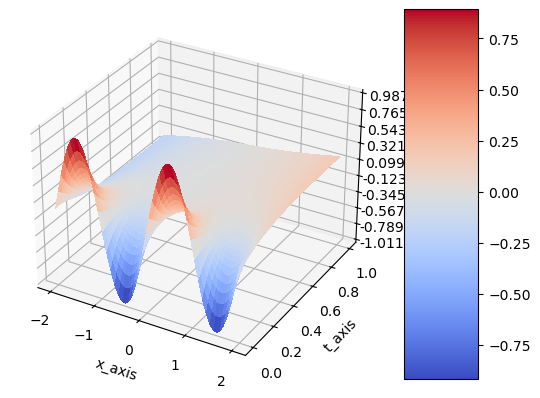

In [63]:
# Plotting the results
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Creating meshgrid for visualization
x_visual = np.arange(-2.0 , 2.0, 0.002)
t_visual = np.arange(0, 1.0, 0.002)
ms_x_visual, ms_t_visual = np.meshgrid(x_visual, t_visual)
## np.ravel returns a flattened and contiguous 1-D array containing the elements of the input.
## A copy is created only if necessary.
x_visual = np.ravel(ms_x_visual).reshape(-1, 1)
t_visual = np.ravel(ms_t_visual).reshape(-1, 1)

# Converting to PyTorch tensors
pt_x_visual = Variable(torch.from_numpy(x_visual).float(), requires_grad=True).to(device)
pt_t_visual = Variable(torch.from_numpy(t_visual).float(), requires_grad=True).to(device)

# Obtaining network predictions
## In the function net(pt_x_visualization, pt_t_visualization), the training process updates the parameters represented by theta.
pt_u_visual = net(pt_x_visual, pt_t_visual)
u_visual = pt_u_visual.data.cpu().numpy()
ms_u_visual = u_visual.reshape(ms_x_visual.shape)

# Plotting the surface
surf = ax.plot_surface(ms_x_visual, ms_t_visual, ms_u_visual, cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.0003f'))
ax.set_xlabel("x_axis")
ax.set_ylabel("t_axis")


# Adding colorbar for reference
fig.colorbar(surf, shrink=1, aspect=5)

# Displaying the plot
plt.show()

### 3.6.3 Comparing Training set with Actual Solution Graph

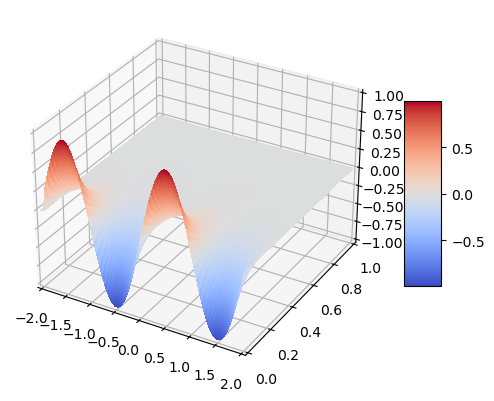

In [206]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# Parameter setting
terminal_time = 1  # terminal time
num_spatial_values = 80  # spatial values for FEM
num_time_values = 1600  # time values/hops; (time_values ~ spatial_values^2)
s_value = 0.25  # s_value := k * ( (dt) / (dx)^2 )

# Uniform mesh
x_values = np.linspace(-2, 2, num_spatial_values)

# Time discretization
time_values = np.linspace(0, terminal_time, num_time_values)

# Definition of the solution u(x, t) to u_t = k * u_xx
u_values = np.zeros((num_spatial_values, num_time_values + 1))  # array to store values of the solution

# Finite Difference Scheme:

u_values[:, 0] = np.sin(np.pi * x_values)  # x_values * (x_values - 1)  # initial condition

for m in range(num_time_values):
    for j in range(1, num_spatial_values - 1):
        if j == 1 or j == num_spatial_values - 1:
            u_values[j, m] = 0  ## Boundary condition
        else:
            u_values[j, m + 1] = u_values[j, m] + s_value * (
                    u_values[j + 1, m] - 2 * u_values[j, m] + u_values[j - 1, m]) ##Inner domain values

# Plot 3D surface
T, X = np.meshgrid(time_values, x_values)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim3d(left=-2, right=2)
ax.set_ylim3d(bottom=0, top=1)
ax.set_zlim3d(bottom=-1, top=1)
surf = ax.plot_surface(X, T, u_values[:, :1600], rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()


### 3.6.4 Result
For the training set case with 50000 iteration, we easily note that the graph shape looks more similar to the actual one, than the case with 20000 iteration. The PINN (Physics-Informed Neural Network) method has the potential to improve the error bound as much as possible by increasing the number of iterations.

# 4. Reference

Files of tutorial :

[1] https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb

[2] https://services.math.duke.edu/education/baltimore/sample.html

[3] 'TwoDNSCH.py' file by Kevin

Paper :

[1] 'Proposal for quantitative benchmark
computations of bubble dynamics' by S. Hysing, S. Turek, D. Kuzmin, N. Parolini, E. Burman, S. Ganesank, and L. Tobiska

+)
[2] 'Solving Allen-Cahn and Cahn-Hilliard Equations using the Adaptive Physics Informed Neural Networks' by Colby L. Wight and Jia Zhao